In [1]:
%load_ext autoreload
%autoreload 2

# ERA5 population aggregation (total precipitation)

In this notebook, we show how to read a sample daily aggregated ERA5 file, which was
downloaded using [cdsapi](https://cds.climate.copernicus.eu/how-to-api). The `ERA5` class
takes care of reading in the data and population and resampling and/or reprojecting to EPSG:4326
(latitude and longitude, also known as WGS84). First we import the necessary classes. See [xarray_exactextract.ipynb](xarray_exactextract.ipynb) for more information.

In [2]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import pandas as pd
import matplotlib.pyplot as plt

from geoglue.country import Country
from geoglue.types import CdoResampling
from geoglue.memoryraster import MemoryRaster
from geoglue.util import geom_plot
from geoglue.era5 import ERA5ZonalStatistics, Dataset

Let's read in some files and plot the population

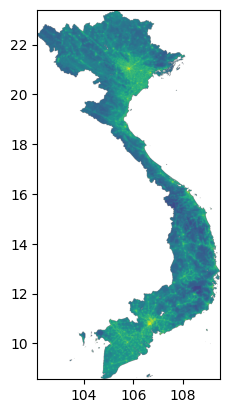

-99999.0

In [3]:
era5_file = "VNM-2020-era5.daily_sum.nc"
VNM = Country("VNM")
population = VNM.population_raster(2020)
population.plot(norm='log')
population.nodata

## ERA5 data

ERA5 requires two parameters: the first, a tuple of ISO 3166-2 3-alpha
(country three letter) code and an admin level (1, 2, or 3) and a
population raster.

In [4]:
era5 = ERA5ZonalStatistics(era5_file, "VNM-2", weights=population, resampling=CdoResampling.remapdis)
era5

ERA5ZonalStatistics VNM-2 statistic=daily_sum
        filename = VNM-2020-era5.daily_sum.nc
        variables = ['tp']

The above representation shows the variable in the ERA5 datasets. ERA5 variables have
two forms - short and long. The short form of '2m_temperature' is 't2m'. The ERA5 class
recognizes this and allows you to refer to the data both by the short and long name.

In [5]:
era5["tp"].shape

(366, 1781, 879)

This shows that the `tp` dataset has the shape (365, 1781, 879) - in this case,
a 1781 by 879 matrix showing the temperature for each day in a year (in this case, we downloaded
data for the year 2020). We can see more information on the variable as well:

In [6]:
era5["tp"].attrs

{'standard_name': 'unknown',
 'long_name': 'Total precipitation',
 'units': 'm',
 'GRIB_paramId': np.int32(228),
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': np.int32(2145),
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': np.int32(1),
 'GRIB_stepType': 'accum',
 'GRIB_gridType': 'regular_ll',
 'GRIB_uvRelativeToGrid': np.int32(0),
 'GRIB_NV': np.int32(0),
 'GRIB_Nx': np.int32(33),
 'GRIB_Ny': np.int32(65),
 'GRIB_cfName': 'unknown',
 'GRIB_cfVarName': 'tp',
 'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid',
 'GRIB_iDirectionIncrementInDegrees': np.float64(0.25),
 'GRIB_iScansNegatively': np.int32(0),
 'GRIB_jDirectionIncrementInDegrees': np.float64(0.25),
 'GRIB_jPointsAreConsecutive': np.int32(0),
 'GRIB_jScansPositively': np.int32(0),
 'GRIB_latitudeOfFirstGridPointInDegrees': np.float64(24.0),
 'GRIB_latitudeOfLastGridPointInDegrees': np.float64(8.0),
 'GRIB_longitudeOfFirstGridPointInDegrees': np.float64(102.0),
 'GRIB_longitudeOfLastGridPointInDegrees': np.float64

All ERA5 datasets will have these three coordinate axes (latitude, longitude and valid_time). We can
see that valid_time ranges from 2020-01-01 to 2020-12-31, so, the entire year of 2020. We can
pick one day from that using either the absolute index with `isel`, or with the full ISO format date
with `sel`. Here, we show the temperature at a specific **time index** *T* where T is in [0, 366] (2020 is a leap year)

In [7]:
T = 150
date = datetime.date(2020, 1, 1) + datetime.timedelta(days=T)
date

datetime.date(2020, 5, 30)

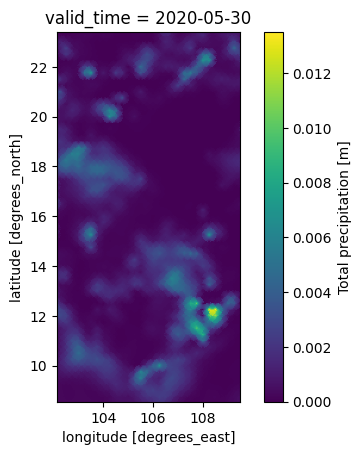

In [8]:
era5["tp"].isel(valid_time=T).plot().axes.set_aspect("equal")

## Population weighted aggregation

Let us look at the population data:

In [9]:
era5.weights.shape

(1781, 879)

To perform **population-weighted aggregation**, we will first upsample the weather data to match the population raster.
This is done to avoid losing the population granularity (1 km x 1 km) which is of a higher resolution than the weather data.
Upsampling is performed using rasterio's [resampling method](https://rasterio.readthedocs.io/en/stable/topics/resampling.html)
which recommends using bilinear resampling for upsampling continuous data. For precipitation, we get more accurate results with distance-weighted average resampling, which is done using CDO's remapdis operator. The resample procedure will create a
raster of the same shape as the population raster, enabling the population raster to be used as weights to the
[exact_extract](https://isciences.github.io/exactextract/exactextract.html) function.

In [10]:
era5["tp"].shape

(366, 1781, 879)

In [11]:
rast = MemoryRaster.from_xarray(era5["tp"].isel(valid_time=T))
rast.shape, VNM.population_raster(2020).shape

((1781, 879), (1781, 879))

In [12]:
rast.griddes

CdoGriddes(gridtype='lonlat', gridsize=1565499, xsize=879, ysize=1781, xname='longitude', yname='latitude', ylongname='latitude', yunits='degrees_north', xfirst=102.14874960275003, xinc=0.0083333333000013, yfirst=8.557916831327146, yinc=0.0083333333000013, xlongname='longitude', xunits='degrees_east')

In [13]:
population.griddes

CdoGriddes(gridtype='lonlat', gridsize=1565499, xsize=879, ysize=1781, xname='longitude', yname='latitude', ylongname='latitude', yunits='degrees_north', xfirst=102.14874960275003, xinc=0.0083333333, yfirst=8.557916831327146, yinc=0.0083333333, xlongname='longitude', xunits='degrees_east')

In [29]:
population.griddes.approx_equal(rast.griddes)

True

In [14]:
df = era5.zonal_daily("tp", "area_weighted_sum", min_date=date, max_date=date)
df

Zonal daily for variable='tp' using operation='area_weighted_sum(coverage_weight=area_spherical_km2)'


/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/src/geoglue/zonal_stats.py:182: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


,GID_1,GID_2,NAME_1,NAME_2,value,date,weighted_sum,count,ISO3,metric
0,VNM.1_1,VNM.1.1_1,An Giang,An Phú,0.081331,2020-05-30,18.566171,228.280042,VNM,era5.total_precipitation.daily_sum
1,VNM.1_1,VNM.1.3_1,An Giang,Châu Đốc,0.143618,2020-05-30,14.948901,104.087931,VNM,era5.total_precipitation.daily_sum
2,VNM.1_1,VNM.1.4_1,An Giang,Châu Phú,0.065606,2020-05-30,29.774523,453.835524,VNM,era5.total_precipitation.daily_sum
3,VNM.1_1,VNM.1.5_1,An Giang,Châu Thành,0.043737,2020-05-30,15.623261,357.206166,VNM,era5.total_precipitation.daily_sum
4,VNM.1_1,VNM.1.2_1,An Giang,Chợ Mới,0.069954,2020-05-30,25.987729,371.495714,VNM,era5.total_precipitation.daily_sum
...,...,...,...,...,...,...,...,...,...,...
705,VNM.63_1,VNM.63.5_1,Yên Bái,Trấn Yên,0.064252,2020-05-30,40.553941,631.166414,VNM,era5.total_precipitation.daily_sum
706,VNM.63_1,VNM.63.6_1,Yên Bái,Văn Chấn,0.070076,2020-05-30,84.613103,1207.447390,VNM,era5.total_precipitation.daily_sum
707,VNM.63_1,VNM.63.7_1,Yên Bái,Văn Yên,0.077990,2020-05-30,109.456323,1403.473618,VNM,era5.total_precipitation.daily_sum
708,VNM.63_1,VNM.63.8_1,Yên Bái,Yên Bái,0.466739,2020-05-30,50.336617,107.847424,VNM,era5.total_precipitation.daily_sum


In [15]:
df["value"].isna().any()

np.False_

In [16]:
df["value"].describe()

count    710.000000
mean       1.233511
std        5.718568
min        0.000000
25%        0.023912
50%        0.096208
75%        0.423471
max       56.669543
Name: value, dtype: float64

In [17]:
df.to_csv("era5.total_precipitation.daily_sum.csv", index=False)